In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from data_preprocessing import *
from graph_construction import *

In [2]:
def load_all_data(path_train, path_test):
    """
    Loads train and test data from the given paths, normalizes them properly.
    """
    train_data, mean, std, train_labels = extract_and_norm_data('train_32x32.mat')
    test_data, test_labels = extract_test_data('test_32x32.mat', mean, std)
    
    return train_data, train_labels, test_data, test_labels

In [3]:
train_data, train_labels, test_data, test_labels = load_all_data('train_32x32.mat', 'test_32x32.mat')

In [4]:
use_dropout = True; learning_rate = 1e-3
tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
prob = tf.placeholder_with_default(input=tf.constant(1.), shape=[])

labels = tf.one_hot(tf.cast(y, tf.int32), depth=10)
labels = tf.squeeze(labels, axis=1)


W_conv1 = tf.get_variable(name='Wconv1', shape=[5, 5, 3, 32], dtype=tf.float32,
                          initializer=tf.contrib.layers.xavier_initializer_conv2d())
b_conv1 = tf.get_variable(name='bconv1', shape=[32], dtype=tf.float32, initializer=tf.zeros_initializer)

h_conv1 = tf.nn.relu(tf.nn.conv2d(X, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
if use_dropout:
    h_pool1 = tf.nn.dropout(h_pool1, prob)


W_conv2 = tf.get_variable(name='Wconv2', shape=[5, 5, 32, 64], dtype=tf.float32,
                         initializer=tf.contrib.layers.xavier_initializer_conv2d())
b_conv2 = tf.get_variable(name='bconv2', shape=[64], dtype=tf.float32, initializer=tf.zeros_initializer)

h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
if use_dropout:
    h_pool2 = tf.nn.dropout(h_pool2, prob)


W_fc1 = tf.get_variable(name='Wfc1', shape=[8*8*64, 1024], dtype=tf.float32, 
                        initializer=tf.contrib.layers.xavier_initializer())
b_fc1 = tf.get_variable(name='bfc1', shape=[1024], dtype=tf.float32, initializer=tf.zeros_initializer)

h_pool2_flat = tf.reshape(h_pool2, shape=[-1, 8*8*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

if use_dropout:
    h_fc1 = tf.nn.dropout(h_fc1, prob)


W_fc2 = tf.get_variable(name='Wfc2', shape=[1024, 10], dtype=tf.float32, 
                        initializer=tf.contrib.layers.xavier_initializer())
b_fc2 = tf.get_variable(name='bfc2', shape=[10], dtype=tf.float32, initializer=tf.zeros_initializer)

z = tf.matmul(h_fc1, W_fc2) + b_fc2

y_hat = tf.nn.softmax(z)



loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=z))

correct_prediction = tf.equal(tf.argmax(labels,1), tf.argmax(y_hat,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

model = tf.global_variables_initializer()


In [4]:
model, train_op, accuracy, X, y, prob = classifier(1e-3, True)

In [5]:
sess = tf.InteractiveSession()

In [6]:
sess.run(model)

In [26]:
losses = np.array([])
for step in tqdm(range(500)):
    _, cost = sess.run([train_op, accuracy], feed_dict={X: train_data[step * 128:(step + 1)*128], y: train_labels[step * 128:(step + 1)*128]})
    losses = np.append(losses, cost)


100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


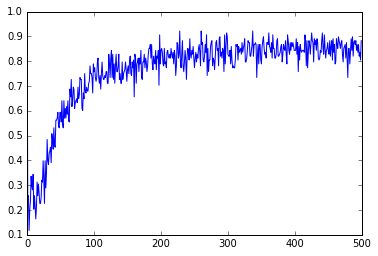

In [27]:
plt.plot(range(losses.shape[0]), losses)
plt.show()

In [14]:
def get_batch(data, labels, step, size):
    m = data.shape[0]
    return range(m)[step * size:(step + 1) * size]

In [23]:
get_batch(train_data, train_labels, 574, 128)

range(73257, 73257)

In [31]:
def test_batch(m, b, i):
    print(range(m)[i*b:(i+1)*b])

In [35]:
test_batch(110, 25)

range(110, 110)
